In [1]:
# Imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

from utils import slide_window, extract_features_single, add_heat,\
                  draw_boxes, find_cars, read_img, draw_labelled_bboxes,\
                  add_extra_heat

from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.core import debugger

In [17]:
# To save as normal python script (easier to git diff)
# !jupyter nbconvert --to script pipeline.ipynb

[NbConvertApp] Converting notebook pipeline.ipynb to script
[NbConvertApp] Writing 9454 bytes to pipeline.py


In [3]:
# Load test images (RGB)
test_image_paths = glob.glob('test_images/test*.jpg')
test_images = [read_img(file, 'cv2') for file in test_image_paths]

In [4]:
PLOT = True
SAVE = False

In [5]:
svc = pickle.load(open('svc_classifier.pkl', 'rb'))
config = pickle.load(open('feature_config.pkl', 'rb'))
X_scaler = pickle.load(open('x_scaler.pkl', 'rb'))

In [6]:
x_start_stop = [None, None]
y_start_stop = [360, 720]
xy_window = (64, 64)
xy_overlap = (0.75, 0.75)

window_sizes = [
    (64, 64),
    (96, 96),
    (120, 120),
    (160, 160),
    (200, 200),
]


parameters = [
    {
        'window_size': (64, 64),
        'y_start_stop': [360, 500],
        'xy_overlap': (0.75, 0.75)
    },
    {
        'window_size': (96, 96),
        'y_start_stop': [360, 560],
        'xy_overlap': (0.75, 0.75)
    },
    {
        'window_size': (120, 120),
        'y_start_stop': [340, 600],
        'xy_overlap': (0.75, 0.75)
    },
    {
        'window_size': (160, 160),
        'y_start_stop': [400, 720],
        'xy_overlap': (0.75, 0.75)
    },
    {
        'window_size': (200, 200),
        'y_start_stop': [400, 720],
        'xy_overlap': (0.75, 0.75)
    },
    {
        'window_size': (260, 260),
        'y_start_stop': [360, 720],
        'xy_overlap': (0.75, 0.75)
    }
]

for param in parameters:
    param['x_start_stop'] = [None, None]
    param['scale'] = param['window_size'][0]/xy_window[0]


# cells_per_window = int(xy_window[0] / config['pix_per_cell'])
# cells_per_step = int((1 - xy_overlap[0]) * cells_per_window)

scales = [ws[0]/xy_window[0] for ws in window_sizes]

In [7]:
def visualise_windows(img, parameters):

    for param in parameters:
        search_area = np.float32([
            [0, param['y_start_stop'][0]], # top-left
            [img.shape[1], param['y_start_stop'][0]], # top-right
            [img.shape[1], param['y_start_stop'][1]], # bottom-right
            [0, param['y_start_stop'][1]] # bottom-left
        ])
        
        window = np.float32([
            [0, param['y_start_stop'][0]], # top-left
            [param['window_size'][0], param['y_start_stop'][0]], # top-right
            [param['window_size'][0], param['y_start_stop'][0] + param['window_size'][1]], # bottom-right
            [0, param['y_start_stop'][0] + param['window_size'][1]] # bottom-left
        ])
        
        plt.figure()
        plt.imshow(img)
        plt.gca().add_patch(Polygon(window, linewidth=4,edgecolor='r',facecolor='r'))
        plt.gca().add_patch(Polygon(search_area, linewidth=4,edgecolor='b',facecolor='none'))

In [8]:
def search_windows(img, windows, clf, scaler, config):
    on_windows = []
    for window in windows:
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        features = extract_features_single(window_img, **config)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)

    return on_windows

# DEPRACATED - using HOG subsampling for efficiency
if False:
    draw_image = np.copy(test_img)
    windows = []
    for size in window_sizes:
        windows.extend(slide_window(test_img,
                           x_start_stop=[None, None],
                           y_start_stop=[400, 700],
                           xy_window=(96, 96),
                           xy_overlap=(0.75, 0.75)))

    hot_windows = search_windows(test_img, windows, svc, X_scaler, config)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    plt.imshow(test_img)
    plt.figure()
    plt.imshow(window_img)

In [9]:
class Frame():
    def __init__(self):
        self.heatmap = None

class Clip():
    def __init__(self):        
        self.frames = deque([], maxlen=8)

    @property
    def heatmap(self):
        # Heatmap is a n average of the previous X frames
        if len(self.frames) == 1:
            return self.frames[0].heatmap
        stacked = np.stack([f.heatmap for f in self.frames])
        return np.mean(stacked, axis=0)

In [10]:
def pipeline(img, clip):
    """
    1. Loop through the different scale windows and keep those which the
       classifier positively identifies as cars
    2. Create a thresholded heatmap from the overlapping windows
    3. Label the heatmap to identify distinct vehicles
    4. Draw labelled boxes from the heatmap
    """
    frame = Frame()
    clip.frames.append(frame)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    
    # 1. Identify "hot" windows
    hot_windows = []
#     for scale in scales:
#         hot_windows.extend(find_cars(img, y_start_stop=y_start_stop, scale=scale,
#                                      svc=svc, X_scaler=X_scaler, **config))
    for param in parameters:
        more_hot_windows = find_cars(img,
                                     y_start_stop=param['y_start_stop'],
                                     scale=param['scale'],
                                     svc=svc, X_scaler=X_scaler, **config)
        
        # Add more heat to larger windows
        if param['window_size'][0] < 200:
            add_heat(heatmap, more_hot_windows, amount=1)
        else:
            add_heat(heatmap, more_hot_windows, amount=2)
        
        hot_windows.extend(more_hot_windows)

    window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)

    # 2. Thresholded heatmap
#     add_heat(heatmap, hot_windows)
    add_extra_heat(heatmap, hot_windows)
    frame.heatmap = heatmap
    
    # Note - frame/clip will always store the unthresholded heatmap
    threshold_heatmap = np.copy(clip.heatmap)

#     threshold = min(2*len(clip.frames, 6)) # So it works for single images or videos
    threshold_heatmap[threshold_heatmap <= 3] = 0
    heatmap_1 = np.copy(threshold_heatmap)
    threshold_heatmap[threshold_heatmap <= 4] = 0
    heatmap_2 = np.copy(threshold_heatmap)
    threshold_heatmap[threshold_heatmap <= 5] = 0
    heatmap_3 = np.copy(threshold_heatmap)

    # TODO - could be cool to overlay the heatmap on the image, or have something
    # which shows that the heat is about to go blue. Could do the bounding box
    # color based on the heatmap number (so higher heatmaps are emphasised)
    
    
    # 3. Label the heatmap
    labelled_array, num_features = label(threshold_heatmap)
    
    # 4. Draw the bounded boxes
    output = np.copy(img)
#     output = draw_labelled_bboxes(img, (labelled_array, num_features), color=(0, 0, 255), thick=6)
#     output = draw_labelled_bboxes(img, label(heatmap_1), color=(255, 0, 0), thick=6)
#     output = draw_labelled_bboxes(output, label(heatmap_2), color=(0, 255, 0), thick=4)
    output = draw_labelled_bboxes(output, label(heatmap_3), color=(0, 0, 255), thick=2)
    
    # -----
    if PLOT:
        images = [
            (window_img, 'All positive windows'),
            (heatmap, 'Heatmap'),
            (threshold_heatmap, 'Thresholded Heatmap'),
            (labelled_array, 'Labelled array'),
            (output, 'Result'),
        ]

        visualise_windows(img, parameters)    

        for i, title in images:
            plt.figure()
            plt.imshow(i)
            plt.title(title)
            if SAVE:
                fig = plt.gcf()
                fig.savefig('output_images/' + "_".join(t for t in title.split(" ")) + '.jpg')

    return output

CPU times: user 3.42 s, sys: 266 ms, total: 3.69 s
Wall time: 3.46 s


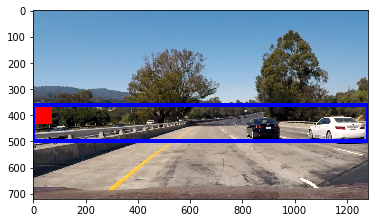

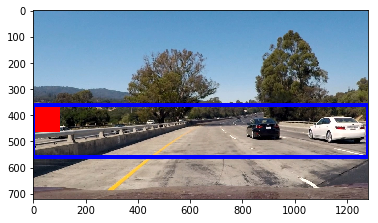

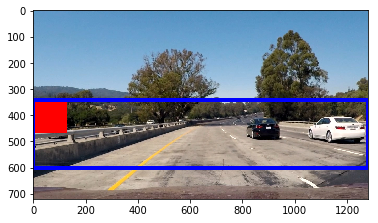

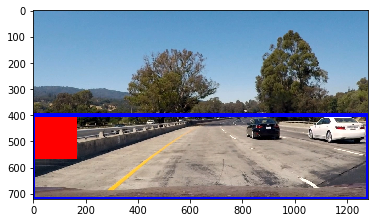

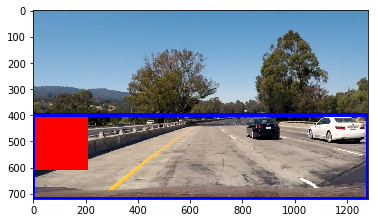

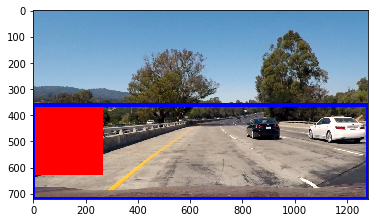

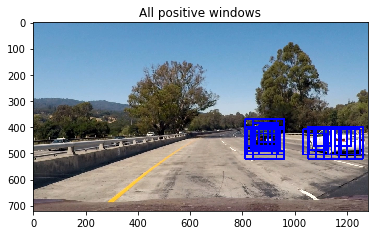

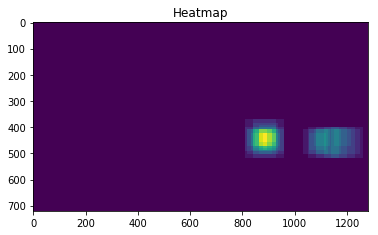

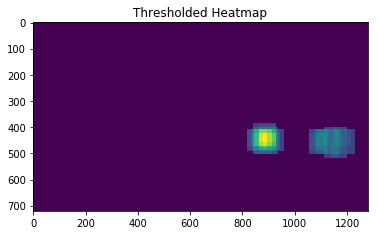

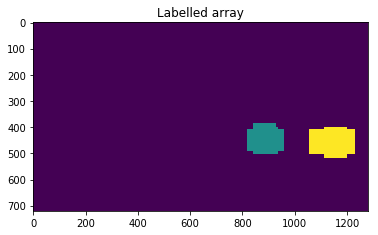

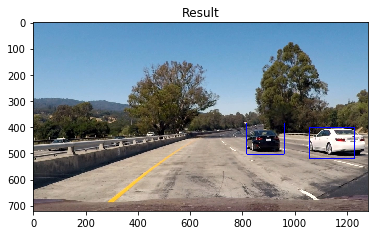

In [11]:
%%time
PLOT = True
SAVE = True
output = pipeline(test_images[0], Clip())

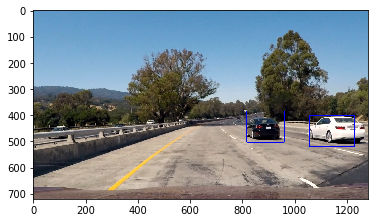

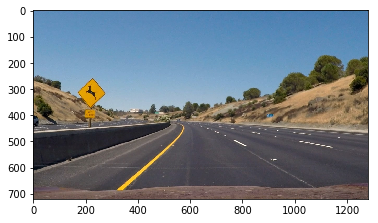

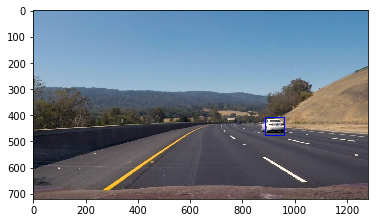

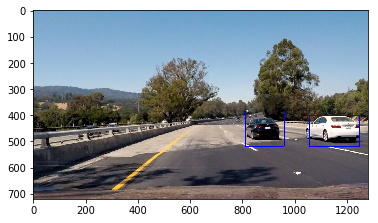

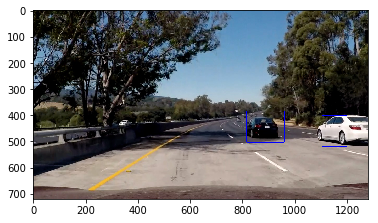

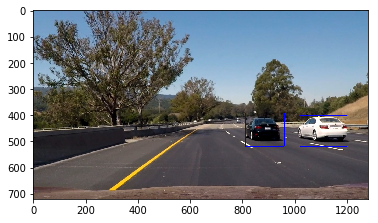

In [12]:
PLOT = False
SAVE = False
for im in test_images:
    plt.figure()
    plt.imshow(pipeline(im, Clip()))

In [13]:
# Videos
output_file = 'output_images/video_out.mp4'
project_video = VideoFileClip("project_video.mp4")
test_video = VideoFileClip("test_video.mp4")
    
white_start = project_video.subclip(4,7)
poor_white = project_video.subclip(20,25)
lost_white = project_video.subclip(28,30)
lost_white2 = project_video.subclip(46,50)


video = project_video

In [14]:
%%time
PLOT = False
SAVE = False
clip = Clip()
def process_image(img):
    return pipeline(img, clip)

video_out = video.fl_image(process_image) #NOTE: this function expects color images!!
%time video_out.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output_images/video_out.mp4
[MoviePy] Writing video output_images/video_out.mp4


100%|█████████▉| 1260/1261 [45:52<00:02,  2.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/video_out.mp4 

CPU times: user 43min 23s, sys: 1min 56s, total: 45min 19s
Wall time: 45min 53s
CPU times: user 43min 25s, sys: 1min 56s, total: 45min 21s
Wall time: 45min 55s


In [15]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_file))

In [16]:
# PLOT = True
# SAVE = False
# output = pipeline(video.get_frame(1), Clip())